In [1]:
import os
import json
from dateutil import parser
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# HARD RESET OF STYLE (prevents Jupyter interference)
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("default")
sns.set_theme(style="white")

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

In [2]:
# Path to the ORIGINAL CyberLab dataset (non-segmented)
ROOT_DIR = "../data/CyberLab"


def collect_entries(file_path):
    """
    Read a JSONL log file and return a list of cleaned user entries
    (all hostnames) with parsed timestamps and non-empty commands,
    sorted by timestamp.
    """
    entries = []
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                continue

            # NOTE: we no longer restrict to hostname == "attacker"
            # All hostnames (attacker, server, laboratory, client, ...) are kept.

            # Parse timestamp
            try:
                ts = parser.isoparse(entry["timestamp_str"])
            except (ValueError, TypeError, KeyError):
                continue

            cmd = entry.get("cmd", "")
            if not cmd:
                continue

            entry["timestamp"] = ts
            entries.append(entry)

    # Ensure chronological order within file
    entries.sort(key=lambda e: e["timestamp"])
    return entries


def build_entry_and_pair_dataframes(root_dir=ROOT_DIR):
    """
    Single pass that builds:
      - df_entries: one row per cleaned command
      - df_pairs:   one row per *consecutive* pair of commands
                    with positive time difference
    """
    entry_rows = []
    pair_rows = []

    for sample_name in os.listdir(root_dir):
        sample_path = os.path.join(root_dir, sample_name)
        if not os.path.isdir(sample_path):
            continue

        for root, dirs, files in os.walk(sample_path):
            for fname in files:
                if not fname.endswith(".json"):
                    continue

                fpath = os.path.join(root, fname)
                entries = collect_entries(fpath)
                if not entries:
                    continue

                # Per-command rows
                for e in entries:
                    cmd = e.get("cmd", "")
                    entry_rows.append({
                        "sample": sample_name,
                        "sandbox_id": e.get("sandbox_id"),
                        "timestamp": e["timestamp"],
                        "cmd": cmd,
                        "cmd_length": len(cmd),
                    })

                # Consecutive pairs
                for i in range(1, len(entries)):
                    prev_e = entries[i - 1]
                    cur_e = entries[i]

                    dt = (cur_e["timestamp"] - prev_e["timestamp"]).total_seconds()
                    # We only skip non-positive dt because you can’t have
                    # a meaningful typing speed otherwise. No upper bound.
                    if dt <= 0:
                        continue

                    cmd = cur_e.get("cmd", "")
                    cmd_len = len(cmd)
                    if cmd_len == 0:
                        continue

                    pair_rows.append({
                        "sample": sample_name,
                        "sandbox_id": cur_e.get("sandbox_id"),
                        "time_diff": dt,              # seconds between commands
                        "cmd_length": cmd_len,        # characters
                        "typing_speed": cmd_len / dt, # characters per second
                        "timestamp": cur_e["timestamp"],
                    })

    df_entries = pd.DataFrame(entry_rows)
    df_pairs = pd.DataFrame(pair_rows)
    return df_entries, df_pairs


def describe_pairs(label: str, df_subset: pd.DataFrame, return_stats: bool = False):
    """
    Print descriptive statistics for a given subset of the pairs dataframe.
    If return_stats=True, also return a dict of the metrics.
    """
    n = len(df_subset)
    if n == 0:
        print(f"\n=== {label}: NO ROWS ===")
        return {} if return_stats else None

    # TS (typing speed, chars/s)
    avg_speed    = df_subset["typing_speed"].mean()
    median_speed = df_subset["typing_speed"].median()
    min_speed    = df_subset["typing_speed"].min()
    max_speed    = df_subset["typing_speed"].max()
    std_speed    = df_subset["typing_speed"].std()

    # Time between commands
    avg_time_diff    = df_subset["time_diff"].mean()
    median_time_diff = df_subset["time_diff"].median()
    min_time_diff    = df_subset["time_diff"].min()
    max_time_diff    = df_subset["time_diff"].max()
    std_time_diff    = df_subset["time_diff"].std()

    # Command length
    avg_cmd_len    = df_subset["cmd_length"].mean()
    median_cmd_len = df_subset["cmd_length"].median()
    min_cmd_len    = df_subset["cmd_length"].min()
    max_cmd_len    = df_subset["cmd_length"].max()
    std_cmd_len    = df_subset["cmd_length"].std()

    # Average time per character
    total_cmd_len    = df_subset["cmd_length"].sum()
    total_time_diff  = df_subset["time_diff"].sum()
    avg_time_per_char = total_time_diff / total_cmd_len if total_cmd_len > 0 else np.nan

    print(f"\n=== {label}: Descriptive Stats ===")
    print(f"Rows: {n:,}")

    print(f"\nTS (chars/s):")
    print(f"  min    = {min_speed:.4f}")
    print(f"  median = {median_speed:.4f}")
    print(f"  mean   = {avg_speed:.4f}")
    print(f"  max    = {max_speed:.4f}")
    print(f"  std    = {std_speed:.4f}")

    print(f"\nTime between commands (s):")
    print(f"  min    = {min_time_diff:.4f}")
    print(f"  median = {median_time_diff:.4f}")
    print(f"  mean   = {avg_time_diff:.4f}")
    print(f"  max    = {max_time_diff:.4f}")
    print(f"  std    = {std_time_diff:.4f}")

    print(f"\nCommand length (characters):")
    print(f"  min    = {min_cmd_len:.0f}")
    print(f"  median = {median_cmd_len:.2f}")
    print(f"  mean   = {avg_cmd_len:.2f}")
    print(f"  max    = {max_cmd_len:.0f}")
    print(f"  std    = {std_cmd_len:.2f}")

    print(f"\nAverage time per character: {avg_time_per_char:.4f} s/char")

    if return_stats:
        return {
            "Rows": n,
            "Average TS": avg_speed,
            "Min TS": min_speed,
            "Max TS": max_speed,
            "Median TS": median_speed,
            "Std TS": std_speed,
            "Average Time Between Commands": avg_time_diff,
            "Min Time Between Commands": min_time_diff,
            "Max Time Between Commands": max_time_diff,
            "Median Time Between Commands": median_time_diff,
            "Std Time Between Commands": std_time_diff,
            "Average Command Length": avg_cmd_len,
            "Min Command Length": min_cmd_len,
            "Max Command Length": max_cmd_len,
            "Median Command Length": median_cmd_len,
            "Std Command Length": std_cmd_len,
            "Average Time Per Character": avg_time_per_char,
        }


# ---------------------------------------------------------------------
# Build dataframes and show RAW stats
# ---------------------------------------------------------------------

df_entries, df_pairs = build_entry_and_pair_dataframes(ROOT_DIR)

print("=== Basic counts ===")
print(f"Total rows (cleaned entries, all hostnames): {len(df_entries):,}")
print(f"Total analysable consecutive pairs:          {len(df_pairs):,}")

if df_pairs.empty:
    raise RuntimeError("No consecutive pairs found - check ROOT_DIR / parsing logic.")

# Keep a raw copy so we can compare later
df_raw = df_pairs.copy()
df = df_raw  # alias for “current working view”

describe_pairs("CORE METRICS - RAW (no thresholds)", df)


=== Basic counts ===
Total rows (cleaned entries, all hostnames): 13,446
Total analysable consecutive pairs:          13,135

=== CORE METRICS - RAW (no thresholds): Descriptive Stats ===
Rows: 13,135

TS (chars/s):
  min    = 0.0000
  median = 0.9090
  mean   = 83.3370
  max    = 55000.0000
  std    = 1083.2841

Time between commands (s):
  min    = 0.0003
  median = 14.6775
  mean   = 442.7199
  max    = 721217.7540
  std    = 11295.1452

Command length (characters):
  min    = 1
  median = 12.00
  mean   = 17.99
  max    = 1049
  std    = 23.58

Average time per character: 24.6130 s/char


## Key assumptions prior to review

- All entries are from humans interactively typing commands
- Copy + paste activity is assumed minimal/negligible
- NO automated/scripted behaviour
- Sessions are self-contained and do not span multiple days (from the paper: median difference between the first and last command was one hour and 13 minutes)
- Session data within each JSON file corresponds to ONE and ONLY ONE user (paper confirms this; each sandbox_id is a unique user session)

## Review of descriptive statistics in the context of the above assumptions

- Typing speed max of 37735 char/s is problematic, inflating mean + stddev. Indicative of automated / script behaviour (unexpected but good to know; violates our assumption the dataset is purely humans interactively 'typing away')
- Max time between commands of 721217 seconds equates to ~8.35 days. Indicative of datetime entries within a session (useractions.json) spanning multiple days.
- Max command length of 1049 is unusual given the median of 13. It might be legitimate, but it is more likely indicative of copy + paste activity or scripted behaviour. Review of associated typing speed required to confirm.

## Initial thoughts + findings

- Median stats for each key metric appear reasonable. Typing (char/s): 0.8463, Time between commands (s): 17.4620, Command length (chars): 13.00
- Mean stats are skewed by extreme outliers, particularly for typing speed and time between commands
- Overall, the dataset appears to contain a significant amount of noise / outliers that violate our initial assumptions. Next, we can establish some plausible 'human-ish' thresholds to filter these out and inspect the cleaned data. Note: this is exploratory and subjective. Hard-coded subjective thresholds are not ideal, nor the intended approach for the final model



## Quick plots to illustrate the unfiltered data distributions + show presence of outliers

- Typing speed distribution plot (count vs char/s)
- Command length distribution plot (count vs character length)
- Hexbin plot (command length vs typing speed)
- 2D histogram (command length vs typing speed with log colour scale)

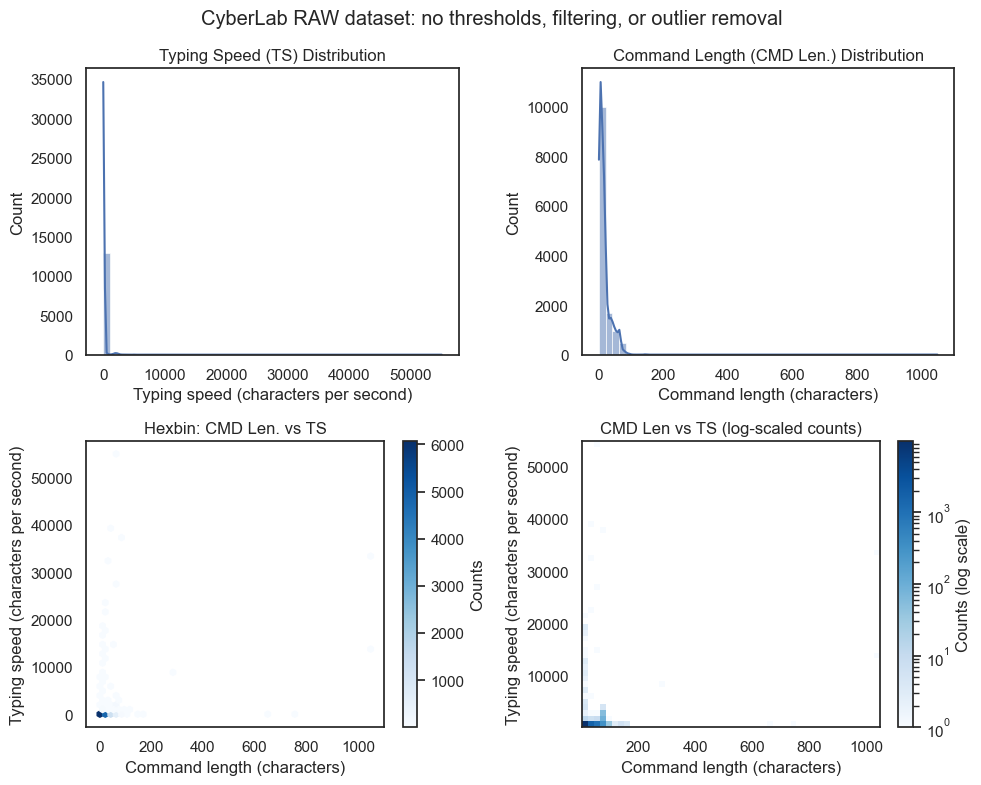

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ---------------------------------------------------------------------
# Top-left: typing speed distribution
# ---------------------------------------------------------------------
sns.histplot(
    df["typing_speed"],
    bins=50,
    kde=True,
    ax=axes[0, 0],
    color="#4c72b0"
)
axes[0, 0].set_title("Typing Speed (TS) Distribution")
axes[0, 0].set_xlabel("Typing speed (characters per second)")
axes[0, 0].set_ylabel("Count")

# ---------------------------------------------------------------------
# Top-right: command length distribution
# ---------------------------------------------------------------------
sns.histplot(
    df["cmd_length"],
    bins=50,
    kde=True,
    ax=axes[0, 1],
    color="#4c72b0"
)
axes[0, 1].set_title("Command Length (CMD Len.) Distribution")
axes[0, 1].set_xlabel("Command length (characters)")
axes[0, 1].set_ylabel("Count")

# ---------------------------------------------------------------------
# Bottom-left: hexbin (command length vs typing speed)
# ---------------------------------------------------------------------
hb = axes[1, 0].hexbin(
    df["cmd_length"],
    df["typing_speed"],
    gridsize=50,
    mincnt=1,
    cmap="Blues"
)
axes[1, 0].set_title("Hexbin: CMD Len. vs TS")
axes[1, 0].set_xlabel("Command length (characters)")
axes[1, 0].set_ylabel("Typing speed (characters per second)")
cbar_hb = fig.colorbar(hb, ax=axes[1, 0])
cbar_hb.set_label("Counts")

# ---------------------------------------------------------------------
# Bottom-right: 2D histogram with log colour scale
# ---------------------------------------------------------------------
hist = axes[1, 1].hist2d(
    df["cmd_length"],
    df["typing_speed"],
    bins=50,
    cmap="Blues",
    norm=LogNorm()
)
axes[1, 1].set_title("CMD Len vs TS (log-scaled counts)")
axes[1, 1].set_xlabel("Command length (characters)")
axes[1, 1].set_ylabel("Typing speed (characters per second)")
cbar_hist = fig.colorbar(hist[3], ax=axes[1, 1])
cbar_hist.set_label("Counts (log scale)")

fig.suptitle("CyberLab RAW dataset: no thresholds, filtering, or outlier removal")
plt.tight_layout()
plt.show()


### Joint KDE: command length vs typing speed in log-log space

This plot looks at the relationship between command length and typing speed after applying a base-10 log transform to both:

- $x = \log_{10}(\text{command length in characters})$
- $y = \log_{10}(\text{typing speed in characters per second})$

Only pairs with `cmd_length > 0` and `typing_speed > 0` are used.

**Why log10 here**

- Both variables span several orders of magnitude (very short vs very long commands, very slow vs extremely fast “typing”).
- On the original scale, the dense human-ish region dominates and the tails are hard to see.
- Working in log10 space compresses the extremes and spreads out the main mass, which is more useful for spotting structure.

**What the plot shows**

- A main, dense blob around:
  - command length ≈ 10-30 characters → $\log_{10} \approx 1$-1.5
  - typing speed ≈ 0.3-3 chars/s → $\log_{10} \approx -0.5$-0.5
  This is consistent with “normal” interactive use.
- Much sparser density at higher log(typing speed), i.e. orders of magnitude faster than typical human typing. These regions line up with the extreme typing-speed outliers seen earlier and are good candidates for automated / copy-paste behaviour.

**Why keep this plot**

- Confirms that the bulk of the data sits in a compact, human-plausible region once extreme values are viewed on a log scale.
- Makes the separation between “normal” and “suspiciously fast” regimes visually obvious, which is helpful when justifying later threshold choices or more formal modelling in log space.


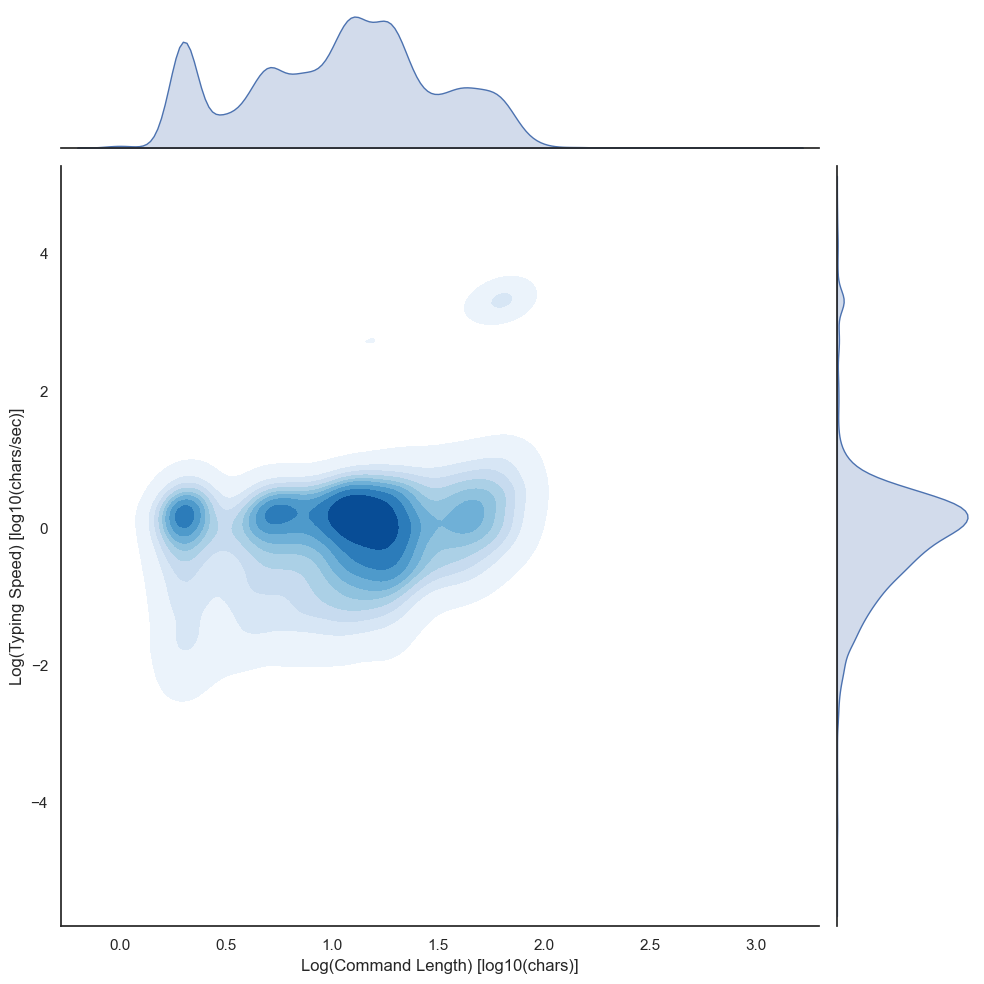

In [4]:
# Joint KDE in log-log space (base 10)
# x = log10(cmd_length), y = log10(typing_speed)

try:
    df_log = df[(df["cmd_length"] > 0) & (df["typing_speed"] > 0)].copy()
    df_log["log_cmd_length"] = np.log10(df_log["cmd_length"])
    df_log["log_typing_speed"] = np.log10(df_log["typing_speed"])

    g_log = sns.jointplot(
        x="log_cmd_length", y="log_typing_speed",
        data=df_log,
        kind="kde", fill=True, cmap="Blues", height=10
    )
    g_log.set_axis_labels(
        "Log(Command Length) [log10(chars)]",
        "Log(Typing Speed) [log10(chars/sec)]"
    )
    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")

## Human-ish filtering heuristic

Analysis up to point has revealed the key metrics of interest, but also highlighted significant outliers that violate our assumptions.
Next, we define a **subjective** human-ish boundary on the 3 key metrics to filter out extreme outliers likely corresponding to pure copy + paste or scripted behaviour.
This is purely EXPLORATORY and SUBJECTIVE. The aim of this human-ish boundary is to establish, once extreme outliers are removed, whether the cleaned data represents what we consider 'plausible' human typing behaviour.
Treat this approach as a: "What does the data look like if we only consider plausible human typing behaviour?".

On typing speed (characters per second), we estbalish a minimum and maximum threshold:
- `MINIMUM_TYPING_SPEED` is set to 0.10 char/s so extremely slow typing is excluded, which may be indicative of long pauses or distractions during the session
- `MAXIMUM_TYPING_SPEED` is set to 10.00 char/s, above which is considered 'superhuman' typing speed likely indicative of copy + paste or scripted behaviour

On time between commands (seconds), we set:
- `MINIMUM_TIME_DIFF` of 1.0 second to exclude ultra-fast consecutive commands likely indicative of scripted behaviour
- `MAXIMUM_TIME_DIFF` of 300.0 seconds (5 minutes) to exclude very long pauses between commands that may indicate breaks in the session or non-interactive behaviour

On command length (characters), we set:
- `MINIMUM_CMD_LENGTH` of 2 characters to exclude single-character commands which are rare and less informative
- `MAXIMUM_CMD_LENGTH` of 100 characters to exclude very long commands likely indicative of copy + paste or scripted behaviour

In [5]:
# Define a “human-ish” box (purely exploratory / subjective)

# Typing speed (characters per second)
MIN_TYPING_SPEED = 0.10
MAX_TYPING_SPEED = 10.00

# Time between commands (seconds)
MIN_TIME_DIFF = 1.0
MAX_TIME_DIFF = 300.0

# Command length (characters)
MIN_CMD_LENGTH = 2
MAX_CMD_LENGTH = 100

mask_human = (
    (df_raw["typing_speed"] >= MIN_TYPING_SPEED) &
    (df_raw["typing_speed"] <= MAX_TYPING_SPEED) &
    (df_raw["time_diff"]    >= MIN_TIME_DIFF) &
    (df_raw["time_diff"]    <= MAX_TIME_DIFF) &
    (df_raw["cmd_length"]   >= MIN_CMD_LENGTH) &
    (df_raw["cmd_length"]   <= MAX_CMD_LENGTH)
)

df_human = df_raw[mask_human].copy()

print("\n=== FILTER: Human-ish heuristic box ===")
print(f"Total RAW pairs:              {len(df_raw):,}")
print(f"Pairs inside human-ish box:   {len(df_human):,} "
      f"({len(df_human)/len(df_raw)*100:.2f}% of all pairs)")

# Quick sanity check on max typing speed before/after
print(f"\nMax typing speed RAW:         {df_raw['typing_speed'].max():.2f} cps")
print(f"Max typing speed human-ish:   {df_human['typing_speed'].max():.2f} cps")

describe_pairs("Human-ish region (heuristic thresholds)", df_human)



=== FILTER: Human-ish heuristic box ===
Total RAW pairs:              13,135
Pairs inside human-ish box:   10,529 (80.16% of all pairs)

Max typing speed RAW:         55000.00 cps
Max typing speed human-ish:   10.00 cps

=== Human-ish region (heuristic thresholds): Descriptive Stats ===
Rows: 10,529

TS (chars/s):
  min    = 0.1000
  median = 1.0130
  mean   = 1.5042
  max    = 10.0000
  std    = 1.5389

Time between commands (s):
  min    = 1.0000
  median = 12.4340
  mean   = 28.3355
  max    = 296.0170
  std    = 39.6074

Command length (characters):
  min    = 2
  median = 13.00
  mean   = 18.32
  max    = 100
  std    = 16.94

Average time per character: 1.5465 s/char


## Human-ish distributions + plots

Same plots as before, but now on the human-ish subset only  
It should now more closely resemble plausible human typing behaviour

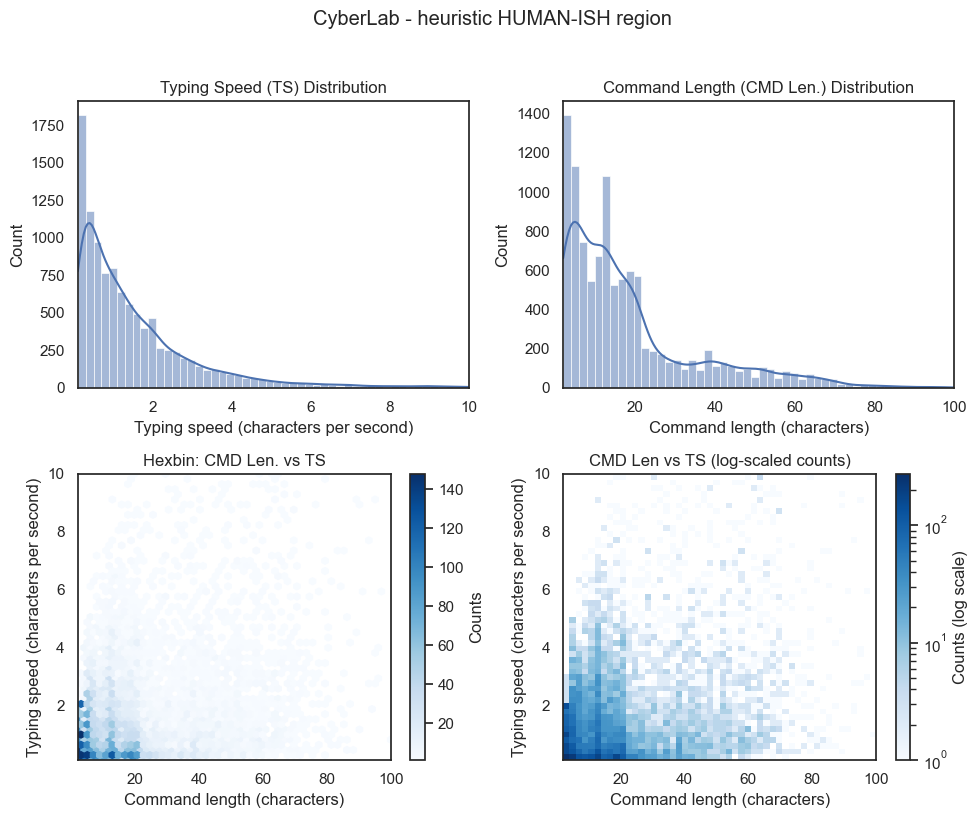

In [6]:
# FIGURE: 2x2 grid on HUMAN-ISH subset

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top-left: typing speed distribution (human-ish)
sns.histplot(
    df_human["typing_speed"],
    bins=50,
    kde=True,
    ax=axes[0, 0],
    color="#4c72b0"
)
axes[0, 0].set_title("Typing Speed (TS) Distribution")
axes[0, 0].set_xlabel("Typing speed (characters per second)")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xlim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)

# Top-right: command length distribution (human-ish)
sns.histplot(
    df_human["cmd_length"],
    bins=50,
    kde=True,
    ax=axes[0, 1],
    color="#4c72b0"
)
axes[0, 1].set_title("Command Length (CMD Len.) Distribution")
axes[0, 1].set_xlabel("Command length (characters)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)

# Bottom-left: hexbin (cmd_length vs typing_speed)
hb = axes[1, 0].hexbin(
    df_human["cmd_length"],
    df_human["typing_speed"],
    gridsize=50,
    mincnt=1,
    cmap="Blues"
)
axes[1, 0].set_title("Hexbin: CMD Len. vs TS")
axes[1, 0].set_xlabel("Command length (characters)")
axes[1, 0].set_ylabel("Typing speed (characters per second)")
axes[1, 0].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)
axes[1, 0].set_ylim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
cbar_hb = fig.colorbar(hb, ax=axes[1, 0])
cbar_hb.set_label("Counts")

# Bottom-right: 2D histogram with log colour scale
hist = axes[1, 1].hist2d(
    df_human["cmd_length"],
    df_human["typing_speed"],
    bins=50,
    cmap="Blues",
    norm=LogNorm()
)
axes[1, 1].set_title("CMD Len vs TS (log-scaled counts)")
axes[1, 1].set_xlabel("Command length (characters)")
axes[1, 1].set_ylabel("Typing speed (characters per second)")
axes[1, 1].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)
axes[1, 1].set_ylim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
cbar_hist = fig.colorbar(hist[3], ax=axes[1, 1])
cbar_hist.set_label("Counts (log scale)")

fig.suptitle("CyberLab - heuristic HUMAN-ISH region", y=1.02)
plt.tight_layout()
plt.show()


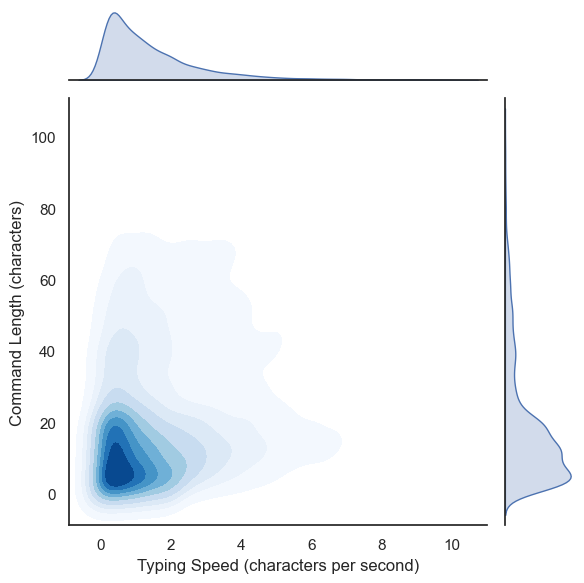

In [7]:
# Joint KDE: Typing speed vs command length - HUMAN-ISH subset

try:
    g = sns.jointplot(
        x="typing_speed",
        y="cmd_length",
        data=df_human,
        kind="kde",
        fill=True,
        cmap="Blues",
        height=6
    )
    # Uncomment if you want the explicit human-ish bounds
    # Prefer no axes limits so the KDE can show density tapering off naturally
    # KDE is an estimation, hence you see density below 0
    # g.ax_joint.set_xlim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
    # g.ax_joint.set_ylim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)

    g.set_axis_labels(
        "Typing Speed (characters per second)",
        "Command Length (characters)"
    )

    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")


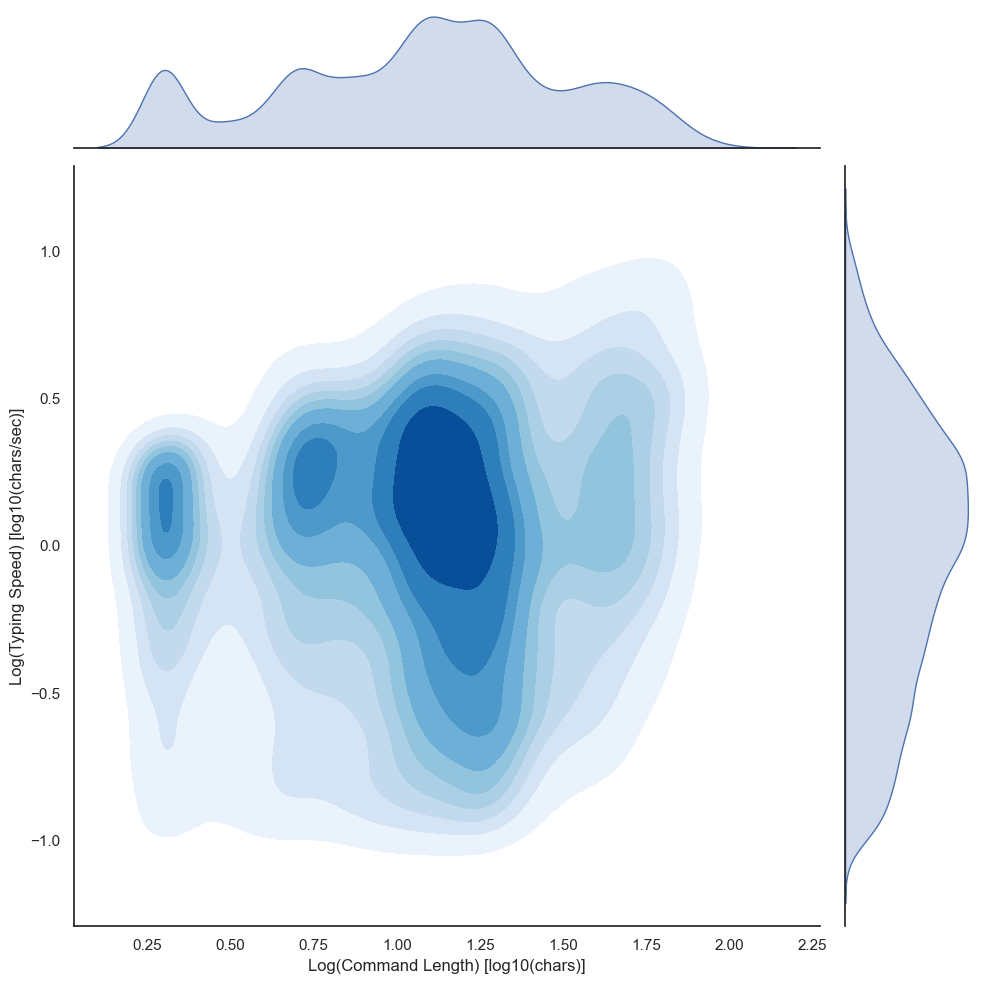

In [8]:
# Joint KDE in log10-log10 space - HUMAN-ISH subset

try:
    df_human_log = df_human[(df_human["cmd_length"] > 0) & (df_human["typing_speed"] > 0)].copy()
    df_human_log["log_cmd_length"] = np.log10(df_human_log["cmd_length"])
    df_human_log["log_typing_speed"] = np.log10(df_human_log["typing_speed"])

    g_log_human = sns.jointplot(
        x="log_cmd_length", y="log_typing_speed",
        data=df_human_log,
        kind="kde", fill=True, cmap="Blues", height=10
    )
    g_log_human.set_axis_labels(
        "Log(Command Length) [log10(chars)]",
        "Log(Typing Speed) [log10(chars/sec)]"
    )
    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")


## Per-sample statistics: RAW

Quick overview of the key metrics within each sample.  
As each sample in `CyberLab/` corresponds to a different sandbox environment featuring a different challenge, it is expected that typing behaviour may vary between samples.  
Aim of this analysis then is to uncover any significant differences within the samples.  
Helps identify any samples that may feature outliers or unusual typing behaviour.

In [9]:
# Per-sample statistics (RAW, no thresholds)

sample_stats_rows_raw = []

for sample_name, df_sample in df_raw.groupby("sample"):
    stats = describe_pairs(f"SAMPLE (RAW): {sample_name}", df_sample, return_stats=True)
    stats["Sample"] = sample_name
    sample_stats_rows_raw.append(stats)

df_sample_stats_raw = (
    pd.DataFrame(sample_stats_rows_raw)
    .set_index("Sample")
    .sort_index()
)

print("\n=== Per-sample stats (RAW, no thresholds) ===")
display(df_sample_stats_raw.round(4))



=== SAMPLE (RAW): House of cards: Descriptive Stats ===
Rows: 1,239

TS (chars/s):
  min    = 0.0000
  median = 0.7290
  mean   = 16.4653
  max    = 3721.1886
  std    = 182.9691

Time between commands (s):
  min    = 0.0153
  median = 18.5499
  mean   = 2755.1760
  max    = 431675.0182
  std    = 28419.4549

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 16.72
  max    = 163
  std    = 13.72

Average time per character: 164.8237 s/char

=== SAMPLE (RAW): Junior hacker: Descriptive Stats ===
Rows: 1,662

TS (chars/s):
  min    = 0.0000
  median = 1.0000
  mean   = 1.8981
  max    = 64.0000
  std    = 3.3399

Time between commands (s):
  min    = 1.0000
  median = 13.5000
  mean   = 602.0596
  max    = 270236.0000
  std    = 9383.0127

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 20.50
  max    = 96
  std    = 20.37

Average time per character: 29.3696 s/char

=== SAMPLE (RAW): Junior hacker adaptive: Descriptive Stats ===
Rows: 4,093

TS

,Rows,Average TS,Min TS,Max TS,Median TS,Std TS,Average Time Between Commands,Min Time Between Commands,Max Time Between Commands,Median Time Between Commands,Std Time Between Commands,Average Command Length,Min Command Length,Max Command Length,Median Command Length,Std Command Length,Average Time Per Character
Sample,,,,,,,,,,,,,,,,,
House of cards,1239,16.4653,0.0000,3721.1886,0.7290,182.9691,2755.1760,0.0153,431675.0182,18.5499,28419.4549,16.7159,1,163,13.0,13.7197,164.8237
Junior hacker,1662,1.8981,0.0000,64.0000,1.0000,3.3399,602.0596,1.0000,270236.0000,13.5000,9383.0127,20.4994,1,96,13.0,20.3743,29.3696
Junior hacker adaptive,4093,114.4342,0.0013,55000.0000,0.9756,1600.2440,49.6710,0.0010,3044.4900,11.9430,127.6679,16.0520,1,97,10.0,17.2930,3.0944
Kobylka 3302,3922,145.5162,0.0002,37735.8491,1.0492,1097.1229,72.4243,0.0003,37916.2137,13.1711,654.1329,19.3376,1,1049,13.0,30.2248,3.7453
SQL injection,170,0.9015,0.0011,11.9467,0.3786,1.4545,239.3086,1.7690,4017.9330,62.5280,556.8261,28.4706,2,103,24.0,21.9809,8.4055
Secret laboratory,1235,25.0796,0.0000,7000.0000,0.6950,320.1229,655.2993,0.0010,721217.7540,20.4140,20521.5972,17.4648,1,754,13.0,31.4901,37.5212
Webmin exploit practice,814,1.0514,0.0020,19.4276,0.5856,1.5226,78.0225,0.5896,2477.6696,22.8108,180.3917,16.6204,1,108,12.0,16.3230,4.6944


## RAW per-sample stats observations

- Inflated average typing speed across House of cards, Junior hacker adaptive, Kobylka 3302, and Secret laboratory. Max TS is in the thousands of char/s which inflates the mean and stddev.
- Average time between commands is inflated for House of cards, Junior hacker, SQL injection, and Secret laboratory. Max time across population is in Secret laboratory at 721217 seconds (~8.35 days).
- Command lengths look reasonable, but the max of 1049 in Kobylka 3302 should still be considered an outlier.
- Median stats across all samples on all metrics remain reasonable, indicating that the bulk of the data is likely human-interactive

## Per-sample statistics: HUMAN-ISH subset

The same per-sample statistics as before, but now on the HUMAN-ISH subset only using the subjective thresholds defined earlier.

- Average TS, as expected, is now much more reasonable given the max TS is capped at 10 char/s
- Average time between commands is also more stable, however ALL samples feature a maximum nearing the cap (300s or 5 minutes). It is therefore plausible, given this dataset, that some users spend extended periods thinking before entering their next command.
- Max command lengths across each sample also hit near the cap of 100 characters.

In [10]:
df_human = df_raw[mask_human].copy()

# Per-sample statistics (HUMAN-ish subset)

sample_stats_rows_human = []

for sample_name, df_sample in df_human.groupby("sample"):
    stats = describe_pairs(f"SAMPLE (HUMAN-ish): {sample_name}", df_sample, return_stats=True)
    stats["Sample"] = sample_name
    sample_stats_rows_human.append(stats)

df_sample_stats_human = (
    pd.DataFrame(sample_stats_rows_human)
    .set_index("Sample")
    .sort_index()
)

print("\n=== Per-sample stats (HUMAN-ish subset) ===")
display(df_sample_stats_human.round(4))


=== SAMPLE (HUMAN-ish): House of cards: Descriptive Stats ===
Rows: 1,012

TS (chars/s):
  min    = 0.1005
  median = 0.9337
  mean   = 1.4294
  max    = 9.4550
  std    = 1.4851

Time between commands (s):
  min    = 1.0890
  median = 14.1239
  mean   = 30.2010
  max    = 284.6167
  std    = 40.9597

Command length (characters):
  min    = 2
  median = 13.00
  mean   = 16.72
  max    = 95
  std    = 12.53

Average time per character: 1.8068 s/char

=== SAMPLE (HUMAN-ish): Junior hacker: Descriptive Stats ===
Rows: 1,403

TS (chars/s):
  min    = 0.1000
  median = 1.1964
  mean   = 1.7568
  max    = 10.0000
  std    = 1.7661

Time between commands (s):
  min    = 1.0000
  median = 11.0000
  mean   = 26.4341
  max    = 294.0000
  std    = 39.5530

Command length (characters):
  min    = 2
  median = 14.00
  mean   = 21.33
  max    = 96
  std    = 20.75

Average time per character: 1.2391 s/char

=== SAMPLE (HUMAN-ish): Junior hacker adaptive: Descriptive Stats ===
Rows: 3,398

TS (char

,Rows,Average TS,Min TS,Max TS,Median TS,Std TS,Average Time Between Commands,Min Time Between Commands,Max Time Between Commands,Median Time Between Commands,Std Time Between Commands,Average Command Length,Min Command Length,Max Command Length,Median Command Length,Std Command Length,Average Time Per Character
Sample,,,,,,,,,,,,,,,,,
House of cards,1012,1.4294,0.1005,9.4550,0.9337,1.4851,30.2010,1.0890,284.6167,14.1239,40.9597,16.7154,2,95,13.0,12.5325,1.8068
Junior hacker,1403,1.7568,0.1000,10.0000,1.1964,1.7661,26.4341,1.0000,294.0000,11.0000,39.5530,21.3336,2,96,14.0,20.7483,1.2391
Junior hacker adaptive,3398,1.4464,0.1001,9.9734,1.0612,1.3953,26.7156,1.0000,296.0170,10.0890,39.0194,17.5756,2,97,11.0,17.8139,1.5200
Kobylka 3302,2971,1.5916,0.1002,10.0000,1.0709,1.6033,26.5438,1.0000,273.8979,12.9142,35.7833,17.9179,2,96,13.0,15.3893,1.4814
SQL injection,123,1.1171,0.1020,7.6428,0.6663,1.2680,60.8302,1.7690,278.8700,40.1970,63.3434,31.3089,2,100,34.0,21.2515,1.9429
Secret laboratory,964,1.4148,0.1006,9.9891,0.8551,1.6234,32.4582,1.0000,245.9160,15.7745,42.0867,17.8506,2,87,15.0,14.4563,1.8183
Webmin exploit practice,658,1.1876,0.1005,9.7712,0.7712,1.3085,33.8615,1.0337,267.5326,15.1267,43.8403,18.3222,2,94,13.0,16.6306,1.8481
